# Projet - Atelier Data Science

## Introduction

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

### Importation des librairies 

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import geopandas as gpd
import unidecode
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from geopandas import GeoDataFrame
from sklearn.preprocessing import LabelEncoder


# Préparation des données

Nous faisons le choix d'appliquer la préparation des données sur les années 2018 et 2022. En effet, nous pourrons donc voir l'impact du COVID sur les DVF.

### Importation des données

On va commencer par faire le traitement des données sur l'année 2022 puis on l'appliquera sur l'année 2018 pour comparer avant et après COVID. 

In [166]:
df_2022 = pd.read_csv("./valeursfoncieres-2022.txt", sep="|", decimal=",")
df_2018 = pd.read_csv("./valeursfoncieres-2018.txt", sep="|", decimal=",")

/var/folders/bk/7b_bwg6x6gjc8hq_4skf_9c00000gn/T/ipykernel_88886/3825086382.py:1: DtypeWarning:

Columns (18,23,24,26,28,41) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/bk/7b_bwg6x6gjc8hq_4skf_9c00000gn/T/ipykernel_88886/3825086382.py:2: DtypeWarning:

Columns (14,18,23,24,26,28,32,41) have mixed types. Specify dtype option on import or set low_memory=False.



In [167]:
print(df_2022.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3803885 entries, 0 to 3803884
Data columns (total 43 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Identifiant de document     float64
 1   Reference document          float64
 2   1 Articles CGI              float64
 3   2 Articles CGI              float64
 4   3 Articles CGI              float64
 5   4 Articles CGI              float64
 6   5 Articles CGI              float64
 7   No disposition              int64  
 8   Date mutation               object 
 9   Nature mutation             object 
 10  Valeur fonciere             float64
 11  No voie                     float64
 12  B/T/Q                       object 
 13  Type de voie                object 
 14  Code voie                   object 
 15  Voie                        object 
 16  Code postal                 float64
 17  Commune                     object 
 18  Code departement            object 
 19  Code commune         

Nous allons chercher le pourcentage de données manquantes par colonnes pour savoir quelles données nous devons garder.

In [168]:
(df_2022.isnull().sum()/len(df_2022))*100

Identifiant de document       100.000000
Reference document            100.000000
1 Articles CGI                100.000000
2 Articles CGI                100.000000
3 Articles CGI                100.000000
4 Articles CGI                100.000000
5 Articles CGI                100.000000
No disposition                  0.000000
Date mutation                   0.000000
Nature mutation                 0.000000
Valeur fonciere                 0.649888
No voie                        34.733621
B/T/Q                          95.374019
Type de voie                   36.984294
Code voie                       1.026398
Voie                            1.029290
Code postal                     1.029816
Commune                         0.000000
Code departement                0.000000
Code commune                    0.000000
Prefixe de section             95.824295
Section                         0.004075
No plan                         0.000000
No Volume                      99.765792
1er lot         

In [169]:
print("En 2022, 1% correspond à ", int(len(df_2022)*0.01), " valeurs du dataset")
print("En 2018, 1% correspond à ", int(len(df_2018)*0.01), " valeurs du dataset")

En 2022, 1% correspond à  38038  valeurs du dataset
En 2018, 1% correspond à  33352  valeurs du dataset


#### Suppression des colonnes sans données

In [170]:
initial_length = len(df_2022.columns)
df_2022.dropna(how='all', axis=1, inplace=True)
print("Suppression de {} colonnes sans données".format(initial_length-len(df_2022.columns)))

Suppression de 8 colonnes sans données


#### Suppression des lignes en double

In [171]:
initial_length = len(df_2022)
df_2022.drop_duplicates(inplace=True)
print("Suppression des doublons: {}".format(initial_length-len(df_2022)))


Suppression des doublons: 269260


#### Suppression des colonnes qui n'ont pas d'intérêt pour l'analyse

In [172]:
df_2022.drop(['Voie', 'B/T/Q'],axis=1, inplace=True)
df_2022.drop(['Prefixe de section', 'Section', 'No plan'],axis=1, inplace=True)
df_2022.drop(['No disposition'],axis=1, inplace=True)
df_2022.drop(['No Volume'],axis=1, inplace=True)
df_2022.drop(['Nature culture speciale', 'Nature culture'],axis=1, inplace=True)
df_2022.drop(['Code type local'],axis=1, inplace=True)
df_2022.drop(['Code voie'],axis=1, inplace=True)
df_2022.drop(['No voie'],axis=1, inplace=True)
df_2022.drop(['Code commune'],axis=1, inplace=True)
df_2022.drop(['Commune'],axis=1, inplace=True)
df_2022.drop(['5eme lot'],axis=1, inplace=True)
df_2022.drop(['4eme lot'],axis=1, inplace=True)
df_2022.drop(['3eme lot'],axis=1, inplace=True)
df_2022.drop(['2eme lot'],axis=1, inplace=True)
df_2022.drop(['1er lot'],axis=1, inplace=True)
df_2022.drop(['Surface Carrez du 1er lot'],axis=1, inplace=True)
df_2022.drop(['Surface Carrez du 2eme lot'],axis=1, inplace=True)
df_2022.drop(['Surface Carrez du 3eme lot'],axis=1, inplace=True)
df_2022.drop(['Surface Carrez du 4eme lot'],axis=1, inplace=True)
df_2022.drop(['Surface Carrez du 5eme lot'],axis=1, inplace=True)

#### Suppression des lignes où la valeur foncière est manquante

In [173]:
indexNames = df_2022[df_2022['Valeur fonciere'].isnull()].index
df_2022.drop(indexNames, inplace=True)

#### Remplissage des valeurs manquantes des colonnes contenant des mètres carré avec des zéros

In [174]:
df_2022['Surface terrain'].fillna(0, inplace=True)

On se rend compte que différentes colonnes ont un pourcentage élevée de données manquantes. On fait donc le choix de supprimer les lignes dont une des valeurs parmis ces colonnes est manquante. 

In [175]:
df_2022.dropna(subset=['Type de voie'], inplace=True)
df_2022.dropna(subset=['Surface reelle bati'], inplace=True)
df_2022.dropna(subset=['Code postal'], inplace=True)
df_2022.dropna(subset=['Type local'], inplace=True)
df_2022.dropna(subset=['Nombre pieces principales'], inplace=True)

In [176]:
df_2022 = df_2022[df_2022['Surface reelle bati'] != 0]

On vérifie ensuite le pourcentage de données manquantes par colonne. On remarque qu'il est maintenant de 0% sauf pour deux colonnes.

In [177]:
(df_2022.isnull().sum()/len(df_2022))*100

Date mutation                0.0
Nature mutation              0.0
Valeur fonciere              0.0
Type de voie                 0.0
Code postal                  0.0
Code departement             0.0
Nombre de lots               0.0
Type local                   0.0
Surface reelle bati          0.0
Nombre pieces principales    0.0
Surface terrain              0.0
dtype: float64

On remarque que la colonne 'Surface terrain' a environ 50% de valeurs manquantes. Cependant, il ne s'agit pas de réelle valeur manquante. Dans les faits, il s'agit des biens immobiliers qui n'ont pas de terrain. On remplace donc toutes les valeurs manquantes par 0. En effet, les biens sans terrain ont donc un terrain de 0 mètre carré.

On remarque que certains bien immobiliers composés de plusieurs types de bien (exemple : dépendance et appartement) sont affichés plusieurs fois. Pour éviter que cela fausse les résultats des algorithmes de prédictions, nous allons donc grouper ces lignes. 

In [178]:
df_2022 = df_2022.groupby(['Nature mutation', 'Valeur fonciere', 'Type de voie','Code postal' ,'Surface terrain', 'Code departement'], as_index=False).agg({
    'Nature mutation': 'first',
    'Date mutation': 'first',
    'Valeur fonciere': 'first',
    'Type de voie': 'first',
    'Code postal': 'first',
    'Code departement': 'first',
    'Nombre de lots': 'first',
    'Type local': lambda x: 'Multiple' if len(set(x)) > 1 else x.unique()[0],
    'Surface reelle bati': 'sum',
    'Nombre pieces principales': 'sum',
    'Surface terrain': 'first'
})

On vérifie donc le taux de valeurs manquantes, il n'y en a plus. 

In [179]:
(df_2022.isnull().sum()/len(df_2022))*100

Nature mutation              0.0
Date mutation                0.0
Valeur fonciere              0.0
Type de voie                 0.0
Code postal                  0.0
Code departement             0.0
Nombre de lots               0.0
Type local                   0.0
Surface reelle bati          0.0
Nombre pieces principales    0.0
Surface terrain              0.0
dtype: float64

#### Création d'une colonne 'Prix au m2'

In [180]:
df_2022['Prix au m2'] = df_2022['Valeur fonciere'] / (df_2022['Surface reelle bati'])

#### Division de la date en 3 colonnes différentes

In [181]:
df_2022['Date mutation'] = pd.to_datetime(df_2022['Date mutation'], format='%d/%m/%Y')
df_2022['year'] = df_2022['Date mutation'].dt.year
df_2022['month'] = df_2022['Date mutation'].dt.month
df_2022['day'] = df_2022['Date mutation'].dt.day
df_2022 = df_2022.drop('Date mutation', axis=1)

#### Changement du nom des colonnes

In [182]:
columns = {}
for index, column_name in enumerate(df_2022.columns):
    columns[column_name] = unidecode.unidecode(column_name.replace(' ','_').replace('\'','_').lower())
df_2022.rename(columns=columns, inplace=True)

#### Suppression des valeurs aberrantes

In [183]:
df_2022 = df_2022[df_2022['valeur_fonciere'] <= 15000000]


#### Traitement des données similaires pour l'année 2018

In [184]:
(df_2018.isnull().sum()/len(df_2018))*100

initial_length = len(df_2018.columns)
df_2018.dropna(how='all', axis=1, inplace=True)
print("Suppression de {} colonnes sans données".format(initial_length-len(df_2018.columns)))

initial_length = len(df_2018)
df_2018.drop_duplicates(inplace=True)
print("Suppression des doublons: {}".format(initial_length-len(df_2018)))

df_2018.drop(['Voie', 'B/T/Q'],axis=1, inplace=True)
df_2018.drop(['Prefixe de section', 'Section', 'No plan'],axis=1, inplace=True)
df_2018.drop(['No disposition'],axis=1, inplace=True)
df_2018.drop(['No Volume'],axis=1, inplace=True)
df_2018.drop(['Nature culture speciale', 'Nature culture'],axis=1, inplace=True)
df_2018.drop(['Code type local'],axis=1, inplace=True)
df_2018.drop(['Code voie'],axis=1, inplace=True)
df_2018.drop(['No voie'],axis=1, inplace=True)
df_2018.drop(['Code commune'],axis=1, inplace=True)
df_2018.drop(['Commune'],axis=1, inplace=True)
df_2018.drop(['5eme lot'],axis=1, inplace=True)
df_2018.drop(['4eme lot'],axis=1, inplace=True)
df_2018.drop(['3eme lot'],axis=1, inplace=True)
df_2018.drop(['2eme lot'],axis=1, inplace=True)
df_2018.drop(['1er lot'],axis=1, inplace=True)
df_2018.drop(['Surface Carrez du 1er lot'],axis=1, inplace=True)
df_2018.drop(['Surface Carrez du 2eme lot'],axis=1, inplace=True)
df_2018.drop(['Surface Carrez du 3eme lot'],axis=1, inplace=True)
df_2018.drop(['Surface Carrez du 4eme lot'],axis=1, inplace=True)
df_2018.drop(['Surface Carrez du 5eme lot'],axis=1, inplace=True)


indexNames = df_2018[df_2018['Valeur fonciere'].isnull()].index
df_2018.drop(indexNames, inplace=True)

df_2018['Surface terrain'].fillna(0, inplace=True)

df_2018.dropna(subset=['Type de voie'], inplace=True)
df_2018.dropna(subset=['Surface reelle bati'], inplace=True)
df_2018.dropna(subset=['Code postal'], inplace=True)
df_2018.dropna(subset=['Type local'], inplace=True)
df_2018.dropna(subset=['Nombre pieces principales'], inplace=True)

df_2018 = df_2018[df_2018['Surface reelle bati'] != 0]

df_2018 = df_2018.groupby(['Nature mutation', 'Valeur fonciere', 'Type de voie','Code postal' ,'Surface terrain', 'Code departement'], as_index=False).agg({
    'Nature mutation': 'first',
    'Date mutation': 'first',
    'Valeur fonciere': 'first',
    'Type de voie': 'first',
    'Code postal': 'first',
    'Code departement': 'first',
    'Nombre de lots': 'first',
    'Type local': lambda x: 'Multiple' if len(set(x)) > 1 else x.unique()[0],
    'Surface reelle bati': 'sum',
    'Nombre pieces principales': 'sum',
    'Surface terrain': 'first'
})

df_2018['Date mutation'] = pd.to_datetime(df_2018['Date mutation'], format='%d/%m/%Y')
df_2018['year'] = df_2018['Date mutation'].dt.year
df_2018['month'] = df_2018['Date mutation'].dt.month
df_2018['day'] = df_2018['Date mutation'].dt.day
df_2018 = df_2018.drop('Date mutation', axis=1)

df_2018['Prix au m2'] = df_2018['Valeur fonciere'] / (df_2018['Surface reelle bati'])

columns = {}
for index, column_name in enumerate(df_2018.columns):
    columns[column_name] = unidecode.unidecode(column_name.replace(' ','_').replace('\'','_').lower())
df_2018.rename(columns=columns, inplace=True)

df_2018 = df_2018[df_2018['valeur_fonciere'] <= 15000000]

(df_2018.isnull().sum()/len(df_2022))*100


Suppression de 8 colonnes sans données
Suppression des doublons: 120210


nature_mutation              0.0
valeur_fonciere              0.0
type_de_voie                 0.0
code_postal                  0.0
code_departement             0.0
nombre_de_lots               0.0
type_local                   0.0
surface_reelle_bati          0.0
nombre_pieces_principales    0.0
surface_terrain              0.0
year                         0.0
month                        0.0
day                          0.0
prix_au_m2                   0.0
dtype: float64

In [185]:
df_combined = pd.concat([df_2018, df_2022])
df_combined = df_combined.reset_index(drop=True)

In [186]:
df_combined['code_departement'] = df_combined['code_departement'].replace('2A', '211')
df_combined['code_departement'] = df_combined['code_departement'].replace('2B', '222')

________________________________________________________________________________________________________________________

# Analyse Exploratoire des Données

#### Choix de la variable cible 

Nous faisons le choix de fdslfkjdskf  fd

#### DataViz n°1 : fdsfds

In [187]:
grouped_df_2018 = df_2018.groupby('code_departement')['valeur_fonciere'].sum().reset_index()
grouped_df_2022 = df_2022.groupby('code_departement')['valeur_fonciere'].sum().reset_index()
merged_df = pd.merge(grouped_df_2018, grouped_df_2022, on='code_departement', suffixes=('_2018', '_2022'))
merged_df['difference'] = merged_df['valeur_fonciere_2022'] - merged_df['valeur_fonciere_2018']
top20_diff_df = merged_df.sort_values('difference', ascending=False).head(20)
top20_diff_df = top20_diff_df.sort_values('difference', ascending=True)
top20_diff_df['x_axis_order'] = range(1, len(top20_diff_df) + 1)
fig = px.bar(top20_diff_df, x='x_axis_order', y='difference', 
             color='difference', 
             labels={'difference':'Différence des valeurs foncières', 
                     'x_axis_order':'Rang du département'},
             hover_data=['code_departement'],
             title="Top 20 départements avec les plus grandes différences de valeurs foncières entre 2018 et 2022")
fig.update_traces(text=top20_diff_df['code_departement'], textposition='inside')

fig.show()

#### DataViz n°2 : fdsfds

In [188]:
dep_file = "./idf_dep.geojson"
dep_map = gpd.read_file(dep_file)
dep_map.sort_values("code")
dep_map=dep_map.rename(columns={ 'code': 'code_departement' })
dep_map['code_departement'] = dep_map['code_departement'].astype(int)
sur_dep = df_combined[['prix_au_m2','code_departement']].copy()
sur_dep=sur_dep.groupby("code_departement").mean()
sur_dep = sur_dep.merge(dep_map, on='code_departement', suffixes=(False, False))
sur_dep = GeoDataFrame(sur_dep,geometry = "geometry")
fig = px.choropleth_mapbox(sur_dep,
                           geojson=sur_dep.geometry,
                           locations=sur_dep.index,
                           color="prix_au_m2",
                           hover_name =sur_dep.code_departement,
                           center={"lat": 46.6061, "lon": 1.875277},
                           mapbox_style="open-street-map",
                           color_continuous_scale="blues",
                           zoom=4.0)
fig.show()

#### DataViz n°3 : fdsfds

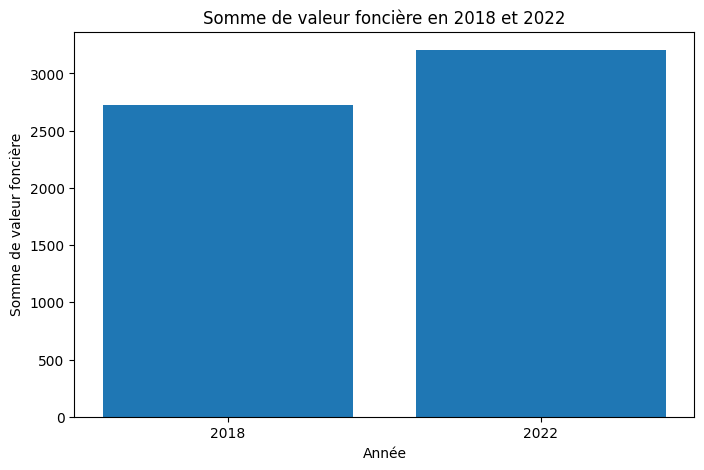

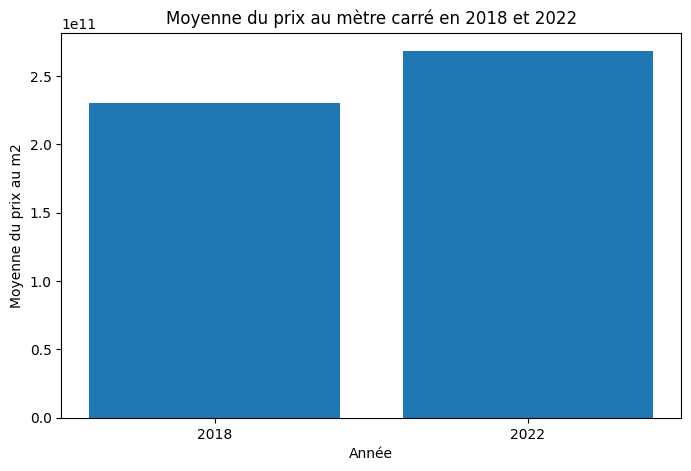

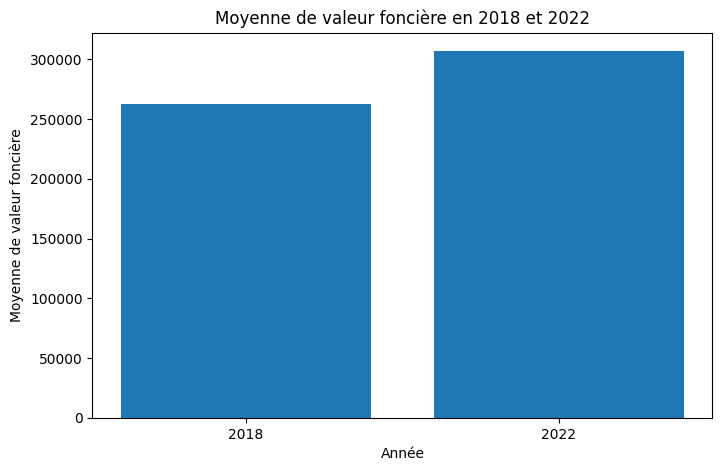

In [189]:
# Somme de la colonne 'valeur_fonciere' en 2018 et 2022
totaux_2018 = df_2018['valeur_fonciere'].sum()
totaux_2022 = df_2022['valeur_fonciere'].sum()

# Moyenne de la colonne 'prix_au_m2' en 2018 et 2022
total_2018 = df_2018['prix_au_m2'].mean()
total_2022 = df_2022['prix_au_m2'].mean()

# Moyenne de la colonne 'valeur_fonciere' en 2018 et 2022
mean_2018 = df_2018['valeur_fonciere'].mean()
mean_2022 = df_2022['valeur_fonciere'].mean()

# Création des graphiques
labels = ['2018', '2022']
totals = [total_2018, total_2022]
means = [mean_2018, mean_2022]
totaux = [totaux_2018, totaux_2022]

# Graphique de la somme de la colonne 'valeur_fonciere'
plt.figure(figsize=(8, 5))
plt.bar(labels, totals)
plt.xlabel('Année')
plt.ylabel('Somme de valeur foncière')
plt.title('Somme de valeur foncière en 2018 et 2022')
plt.show()

# Graphique de la moyenne du prix au m2 
plt.figure(figsize=(8, 5))
plt.bar(labels, totaux)
plt.xlabel('Année')
plt.ylabel('Moyenne du prix au m2')
plt.title('Moyenne du prix au mètre carré en 2018 et 2022')
plt.show()

# Graphique de la moyenne de la colonne 'valeur_fonciere'
plt.figure(figsize=(8, 5))
plt.bar(labels, means)
plt.xlabel('Année')
plt.ylabel('Moyenne de valeur foncière')
plt.title('Moyenne de valeur foncière en 2018 et 2022')
plt.show()


#### Valeur foncière en fonction du département sur l'année 2022

In [190]:
grouped_df = df_2022.groupby('code_departement')['valeur_fonciere'].sum().reset_index()
top20_df = grouped_df.sort_values('valeur_fonciere', ascending=False).head(20)
top20_df = top20_df.sort_values('valeur_fonciere', ascending=True)
top20_df['x_axis_order'] = range(1, len(top20_df) + 1)
fig = px.bar(top20_df, x='x_axis_order', y='valeur_fonciere', 
             color='valeur_fonciere', 
             labels={'valeur_fonciere':'Somme des valeurs foncières', 
                     'x_axis_order':'Rang du département'},
             hover_data=['code_departement'],
             title="Top 20 départements avec les plus grandes valeurs foncières")
fig.update_traces(text=top20_df['code_departement'], textposition='inside')
fig.show()


#### Valeur foncière moyenne en fonction du département (top 20)

In [214]:
grouped_df = df_2022.groupby('code_departement')['valeur_fonciere'].mean().reset_index()
top20_df = grouped_df.sort_values('valeur_fonciere', ascending=False).head(20)
top20_df = top20_df.sort_values('valeur_fonciere', ascending=True)
top20_df['x_axis_order'] = range(1, len(top20_df) + 1)
fig = px.bar(top20_df, x='x_axis_order', y='valeur_fonciere', 
             color='valeur_fonciere', 
             labels={'valeur_fonciere':'Somme des valeurs foncières', 
                     'x_axis_order':'Rang du département'},
             hover_data=['code_departement'],
             title="Top 20 départements avec les plus grandes valeurs foncières")
fig.update_traces(text=top20_df['code_departement'], textposition='inside')
fig.show()

#### Prix moyen au mètre carré en fonction du département (top 20)

In [192]:
grouped_df = df_2022.groupby('code_departement')['prix_au_m2'].mean().reset_index()
top20_df = grouped_df.sort_values('prix_au_m2', ascending=False).head(20)
top20_df = top20_df.sort_values('prix_au_m2', ascending=True)
top20_df['x_axis_order'] = range(1, len(top20_df) + 1)
fig = px.bar(top20_df, x='x_axis_order', y='prix_au_m2', 
             color='prix_au_m2', 
             labels={'prix_au_m2':'Moyenne du prix au m2', 
                     'x_axis_order':'Rang du département'},
             title="Top 20 départements avec les plus grandes moyennes du prix au m2")
fig.update_traces(text=top20_df['code_departement'], textposition='inside')
fig.show()

#### DataViz n°434 : fdsjf

In [193]:
nature = df_2022.groupby('nature_mutation')['valeur_fonciere'].sum().reset_index().sort_values('valeur_fonciere',ascending = False).head(6)
nature = nature.rename(columns = {'valeur_fonciere':'sum'})
fig = px.pie(nature, values='sum', names='nature_mutation')
fig.show()

#### Matrice de corrélation

<Axes: >

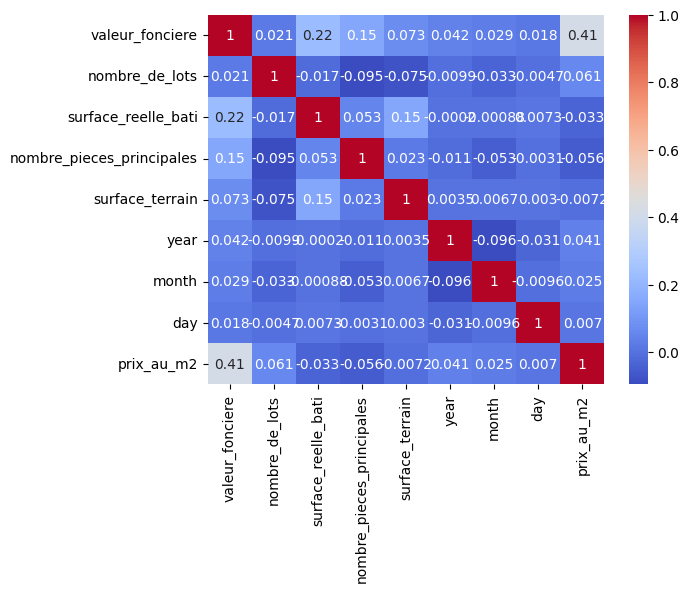

In [194]:
numerical_columns = df_combined.select_dtypes(include=['int', 'float']).columns
columns_to_exclude = ['code_postal']
numeric_df = df_combined[numerical_columns].drop(columns=columns_to_exclude)
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Modèle Machine Learning

## Modèle non-supervisé : K-means

#### Sélection des variables pertinentes pour le modèle

In [195]:
selected_features = ['nature_mutation','valeur_fonciere', 'nombre_de_lots', 'surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain', 'prix_au_m2', 'code_departement', 'type_local', 'month']

#### Encodage des variables catégorielles 

In [196]:
categorical_features = ['nature_mutation','code_departement', 'type_local', 'month']
df_combined[categorical_features] = df_combined[categorical_features].astype(str)
numerical_features = list(set(selected_features) - set(categorical_features))
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  
        ('cat', OneHotEncoder(), categorical_features)  
    ])

X = preprocessor.fit_transform(df_combined[selected_features])

#### Utilisation de la Elbow Method pour déterminer le nombre optimisé de cluster

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



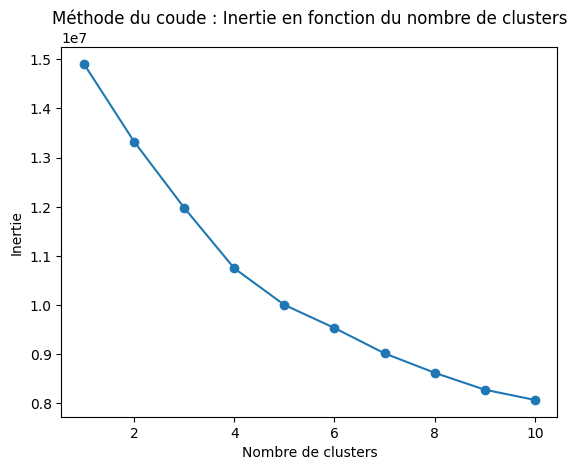

In [197]:
inertia = []
max_clusters = 10
for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude : Inertie en fonction du nombre de clusters')
plt.show()


#### Instanciation du modèle K-means avec le nombre de clusters souhaité

In [198]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)

In [199]:
kmeans.fit(X)
labels = kmeans.labels_
df_combined['cluster_label'] = labels
cluster_centers = kmeans.cluster_centers_
print("Centres des clusters :")
print(cluster_centers)

Centres des clusters :
[[ 1.15192265e-01 -8.35849217e-02  8.76839325e-01 -1.33705878e-01
  -9.14619406e-02 -3.01647001e-01  4.39168938e-03  1.99398107e-03
   5.70149148e-05  9.26005427e-01  6.73808427e-02  1.71044744e-04
   7.43197119e-03  2.70589704e-03  5.36094293e-03  2.46088700e-03
   4.20924166e-02  1.03258634e-02  1.36065324e-03  1.44078231e-03
   7.71550482e-03  1.62107271e-03  1.48546967e-03  1.85991898e-03
   7.05444000e-03  2.91084254e-03  3.77531193e-03  2.22049979e-03
   2.68124194e-04  1.70890650e-03  7.90658183e-03  7.38882477e-03
   2.52406569e-03  3.15277069e-03  7.82953465e-03  3.15277069e-03
   1.20054919e-02  3.16170817e-02  1.05554640e-03  2.79758318e-02
   3.28868192e-02  1.76700008e-02  5.94804246e-04  7.21315719e-03
   1.90167855e-02  2.82454970e-03  1.98011258e-03  6.67999069e-03
   1.86762370e-03  1.09807644e-02  1.71507027e-03  2.24993181e-02
   7.48744516e-03  8.69092215e-04  1.87841030e-03  3.80613080e-04
   5.96191096e-03  2.93087481e-03  2.38229887e-03  4.

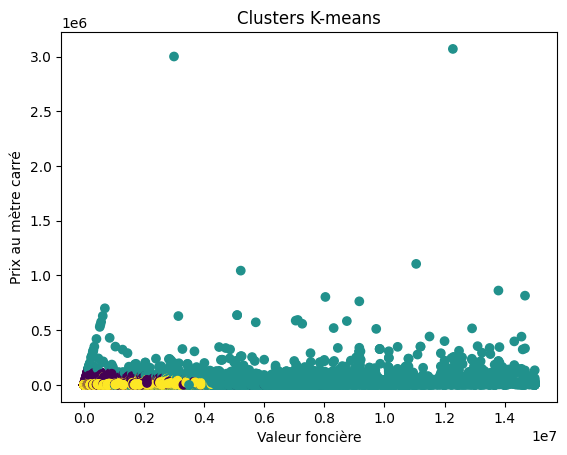

In [200]:
plt.scatter(df_combined['valeur_fonciere'], df_combined['prix_au_m2'], c=df_combined['cluster_label'], cmap='viridis')
plt.xlabel('Valeur foncière')
plt.ylabel('Prix au mètre carré')
plt.title('Clusters K-means')
plt.show()

In [201]:
for cluster_label, cluster_data in df_combined.groupby('cluster_label'):
    print(f"\nCluster {cluster_label}:")
    print(cluster_data[selected_features].describe())


Cluster 0:
       valeur_fonciere  nombre_de_lots  surface_reelle_bati   
count     6.489530e+05   648953.000000        648953.000000  \
mean      2.414134e+05        1.563696            80.463507   
std       2.814669e+05        1.247563           110.725309   
min       1.500000e-01        0.000000             1.000000   
25%       1.050000e+05        1.000000            43.000000   
50%       1.690000e+05        1.000000            64.000000   
75%       2.700000e+05        2.000000            87.000000   
max       7.950152e+06      330.000000          9805.000000   

       nombre_pieces_principales  surface_terrain     prix_au_m2  
count              648953.000000    648953.000000  648953.000000  
mean                    3.031653         2.190901    3643.102282  
std                     2.063715        57.693118    3253.796215  
min                     0.000000         0.000000       0.000042  
25%                     2.000000         0.000000    1700.000000  
50%               

Cluster 0 : Ce cluster a une valeur foncière moyenne de 241 379 €, avec une grande variation allant jusqu'à 7 950 152 €.
La plupart des propriétés dans ce cluster ont une surface réelle bâtie relativement petite, avec une moyenne de 80 m².
Le nombre moyen de pièces principales est d'environ 3, avec un maximum de 46.
La surface du terrain est principalement nulle (0 m² en moyenne), indiquant que ces propriétés sont généralement des appartements ou des terrains sans terrain attenant.
Le prix moyen au mètre carré dans ce cluster est d'environ 3 643 €, avec une variation allant jusqu'à 138 000 €.

Cluster 1 : La valeur foncière moyenne dans ce cluster est de 273 463 €, avec une variabilité allant jusqu'à 4 403 860 €.
Les propriétés de ce cluster ont en moyenne une surface réelle bâtie de 145 m², avec une certaine variabilité.
Le nombre moyen de pièces principales est d'environ 4, avec un maximum de 158.
La plupart des propriétés n'ont pas de surface de terrain ou ont une surface relativement petite (environ 685 m² en moyenne).
Le prix moyen au mètre carré dans ce cluster est d'environ 2 387 €.

Cluster 2 : Ce cluster présente des caractéristiques distinctes par rapport aux autres clusters, avec une valeur foncière moyenne élevée de 6 324 128 €.
Les propriétés dans ce cluster ont une surface réelle bâtie élevée, avec une moyenne de 3 824 m² et une grande variabilité.
Le nombre moyen de pièces principales est relativement élevé, avec une moyenne de 8,7 pièces.
La surface du terrain est généralement plus grande dans ce cluster, avec une moyenne de 5 908 m².
Le prix moyen au mètre carré est élevé dans ce cluster, atteignant environ 31 419 €.


Voici des titres suggérés pour chaque cluster en fonction de leurs caractéristiques distinctives :

- Cluster 0 : "Petites propriétés urbaines abordables"
- Cluster 1 : "Propriétés familiales de taille moyenne"
- Cluster 2 : "Propriétés haut de gamme avec de grandes surfaces"

## Modèle supervisé : Random Forest

#### Sélection des données pour réaliser une prédiction du prix au mètre carré en Ile-de-France

In [202]:
df_idf = pd.concat([df_2018, df_2022])
departements_idf = [75, 78, 77, 91, 92, 93, 94, 95]
df_idf = df_idf[df_idf['code_departement'].isin(departements_idf)]
df_idf = df_idf.drop(['month', 'day', 'nombre_de_lots', 'type_de_voie'], axis=1)

#### Division des données en fonctionnalités et cible

In [203]:
X = df_idf.drop('valeur_fonciere', axis=1)
y = df_idf['valeur_fonciere']

In [204]:
num_cols = ['surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain','prix_au_m2']
cat_cols = ['nature_mutation', 'code_postal', 'code_departement', 'type_local', 'year']

In [205]:
for feature in cat_cols:
    encoder = LabelEncoder()
    X[feature] = encoder.fit_transform(X[feature])

In [206]:
scaler = MinMaxScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 


In [208]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [209]:
y_pred = model.predict(X_test)

In [210]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [211]:
threshold = 0.01  # Marge d'erreur de 1%
correct_predictions = sum(abs(y_pred - y_test) / y_test <= threshold)  
percentage_correct = correct_predictions / len(y_test) * 100


In [212]:
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)
print("Percentage of Correct Predictions (within 1% error):", percentage_correct)


Mean Squared Error: 3752838647.85469
Mean Absolute Error: 3052.0488637275853
R-squared: 0.993357046329714
Percentage of Correct Predictions (within 1% error): 96.87011453913155


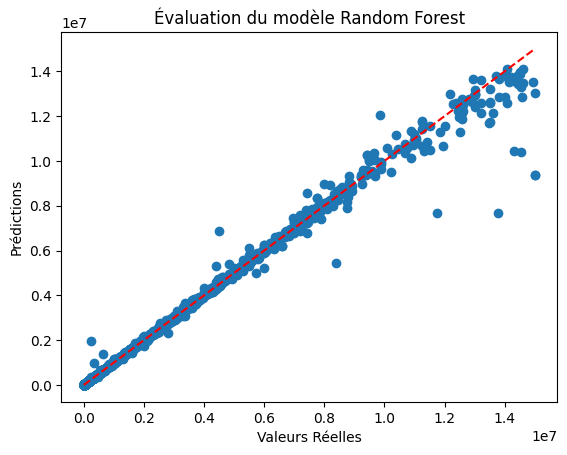

In [213]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ligne de référence pour une prédiction parfaite
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Évaluation du modèle Random Forest')
plt.show()